In [6]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [7]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = get_class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
# if lang_class_name.endswith("HELM"): #TODO: should be removed after .lang inclusion
#     lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = get_class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = get_class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

In [8]:
for f in filters:
    print(vars(f))

{}


Search is started.
0- time: 0.02, count_rollouts: 1, reward: -0.1500484485118679, node: PEPTIDE1{A.S.W.A.G.I.A.F}$$$$
1- time: 0.11, count_rollouts: 2, reward: -0.7128521637404438, node: PEPTIDE1{L.L.G.T.A.R.V.G.F.V.T.D.H.R.E.K.R}$$$$
2- time: 0.28, count_rollouts: 3, reward: -0.674626586886164, node: PEPTIDE1{[ac].F.Q.S.K.G.N.V.F.V.D.G.Y.F.E.R.L.R.A.K.L.[am]}$$$$
3- time: 0.90, count_rollouts: 5, reward: -0.08665213910272741, node: PEPTIDE1{Y.G.A.F.L.A.[am]}$$$$
4- time: 0.97, count_rollouts: 6, reward: -0.010812578597561231, node: PEPTIDE1{G.F.[dF].F.L.R.[am]}$$$$
5- time: 1.03, count_rollouts: 7, reward: -0.37886177697626294, node: PEPTIDE1{A.A.K.Q.M.A.V.N.V.K.F}$$$$
6- time: 1.11, count_rollouts: 8, reward: -0.22226731725164836, node: PEPTIDE1{F.Q.P.D.V.V.G}$$$$
7- time: 1.19, count_rollouts: 9, reward: -0.6380305206407036, node: PEPTIDE1{T.P.R.A.R.R.R.K.K.R.[dW]}$$$$
8- time: 1.26, count_rollouts: 10, reward: -0.46966153927308263, node: PEPTIDE1{K.L.I.K.T.M.L.R.Q.G.Y.G.K.V.K.E.I.L

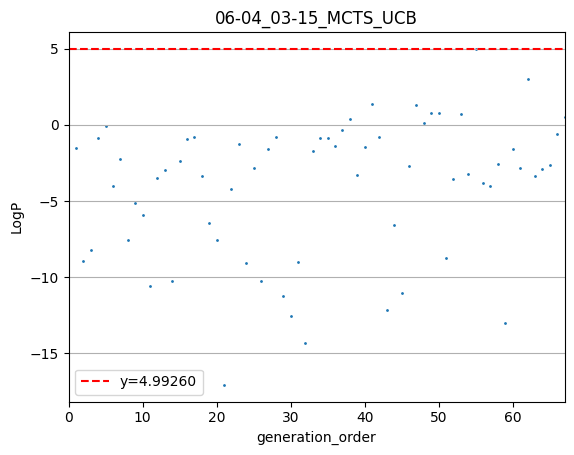

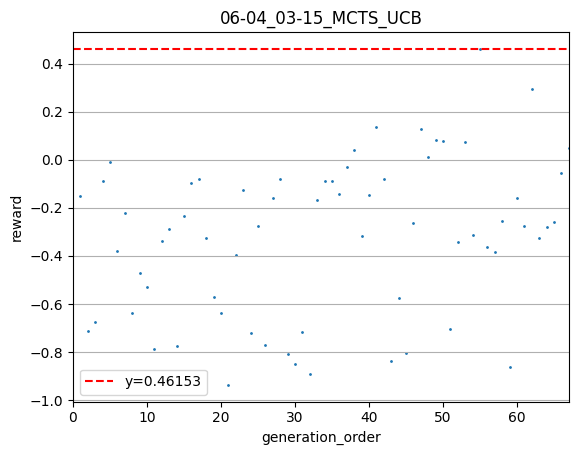

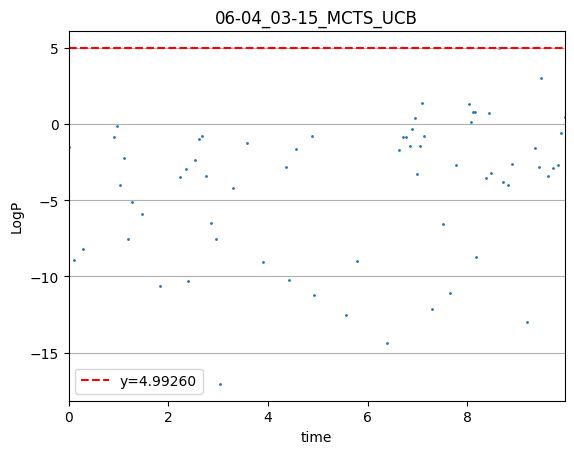

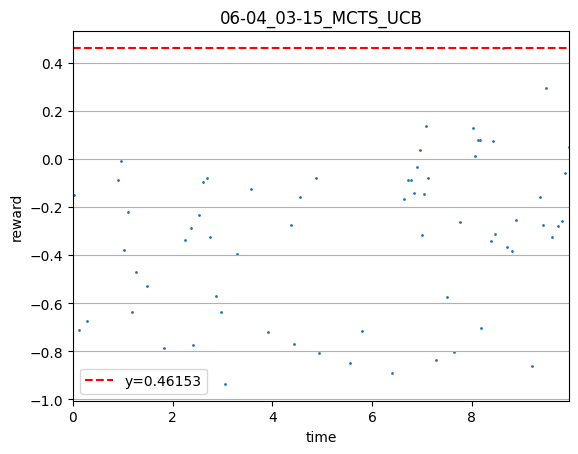

Search is completed.


In [9]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)